## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

### 1. Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import os
import cv2
from tensorflow import random
import shutil
from PIL import UnidentifiedImageError

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [2]:
#set a seed
SEED = 1
np.random.seed(SEED)
random.set_seed(SEED)

### 2. Define Constants

In [30]:
DATADIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\P5-WarmUp\Data for all Projects\cats_dogs_small' 
TEST_DATADIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\P5-WarmUp\Data for all Projects\dog-cat-test1_small'
CATEGORIES = ["Dog", "Cat"]

FAST_RUN = True #False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### 3. Prepare Traning Data

* Let's assume all data in "cats_dogs_small" folder are training data.
* And we will use data from "test1_small" folder as testing data. And will compare predictions visually.

In [4]:
n_cats = 0
n_dogs = 0
for img in os.listdir(DATADIR):
    if img.startswith('cat'):
        n_cats += 1
    elif img.startswith('dog'):
        n_dogs += 1
print('Total number of cats:', n_cats)
print('Total number of dogs:', n_dogs)

Total number of cats: 1236
Total number of dogs: 1239


(280, 300, 3)


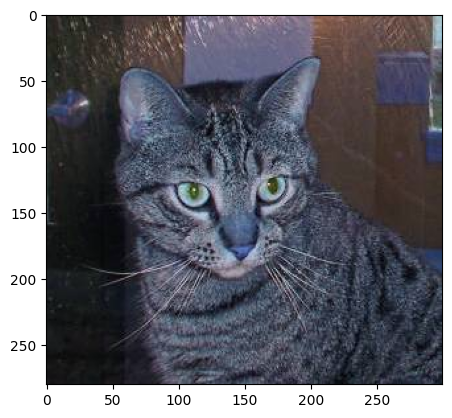

In [5]:
for img in os.listdir(DATADIR):
    img_array = cv2.imread(os.path.join(DATADIR,img), cv2.IMREAD_COLOR)
    plt.imshow(img_array)
    print(img_array.shape)
    break

(150, 150, 3)


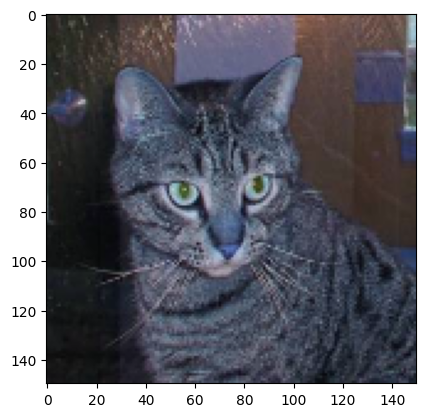

In [6]:
new_array = cv2.resize(img_array, IMAGE_SIZE)
print(new_array.shape)
plt.imshow(new_array)
plt.show()

* 150*150 is the image size we will use for training. Seems to be ok for this case. We can try other sizes later.

In [7]:
[x[0] for x in os.walk(DATADIR)]

['D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\train',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\train\\Cat',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\train\\Dog',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\validation',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\validation\\Cat',
 'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\cats_dogs_small\\validation\\Dog']

In [8]:
categories = []
filenames = []

for dirobject in os.scandir(DATADIR):
    if dirobject.is_file():
        # print(dirobject.name)
        try:
            # print('Loading', dirobject.path)
            load_img(dirobject.path)

            # Second - identify the category and filename if the image is valid
            filenames.append(dirobject.name)

            category = dirobject.name.split('.')[0]
            if category == 'dog':
                categories.append('Dog')
            else:
                categories.append('Cat')


        except UnidentifiedImageError:
            print("Removing: ", dirobject.path)
            os.remove(dirobject.path)
    
df = pd.DataFrame({ 'filename': filenames, 'category': categories})
df

filename category
0         cat.1.jpg      Cat
1     cat.10000.jpg      Cat
2     cat.10018.jpg      Cat
3     cat.10036.jpg      Cat
4     cat.10063.jpg      Cat
...             ...      ...
2470   dog.9938.jpg      Dog
2471   dog.9948.jpg      Dog
2472   dog.9955.jpg      Dog
2473   dog.9980.jpg      Dog
2474   dog.9993.jpg      Dog

[2475 rows x 2 columns]

In [9]:
shutil.rmtree(os.path.join(DATADIR, 'train'))
shutil.rmtree(os.path.join(DATADIR, 'validation'))


os.mkdir(os.path.join(DATADIR, 'train'))
os.mkdir(os.path.join(DATADIR, 'validation'))

os.mkdir(os.path.join(DATADIR, 'train', 'Dog'))
os.mkdir(os.path.join(DATADIR, 'train', 'Cat'))

os.mkdir(os.path.join(DATADIR, 'validation', 'Dog'))
os.mkdir(os.path.join(DATADIR, 'validation', 'Cat'))
          

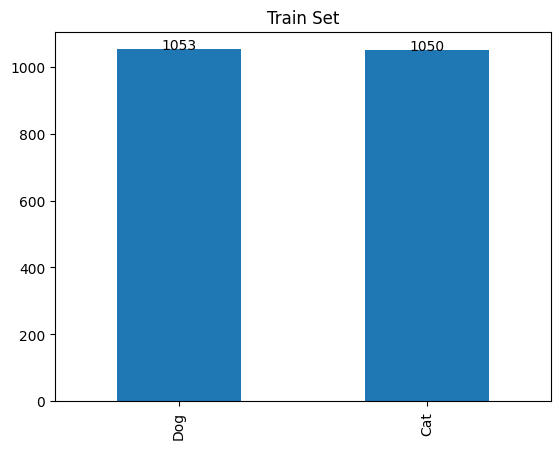

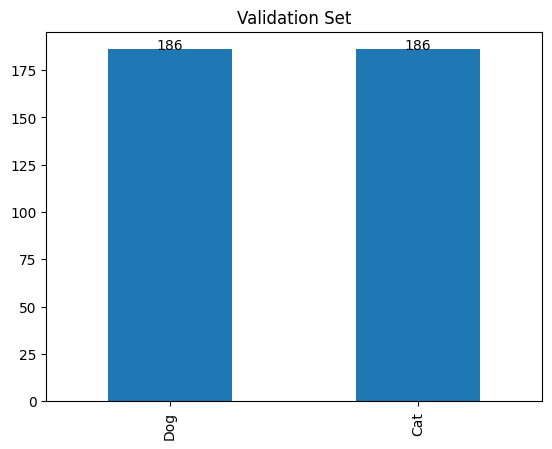

In [10]:
X = df['filename']
y = df['category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED, stratify=y, shuffle=True)

df_train = pd.DataFrame({ 'filename': X_train, 'category': y_train})
df_val = pd.DataFrame({ 'filename': X_val, 'category': y_val})

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_train.name = 'Train Set'
df_val.name = 'Validation Set'


for i in [df_train, df_val]:
    i['category'].value_counts().plot(kind='bar', title=i.name)
    for j in range(len(i['category'].value_counts())):
        plt.text(j, i['category'].value_counts()[j], i['category'].value_counts()[j], ha='center')

    plt.show()   


In [11]:
# copy train images to train folder
for index, row in df_train.iterrows():
    filename = row['filename']
    category = row['category']
    src = os.path.join(DATADIR, filename)

    filename = filename.replace('.', '_', filename.count('.') - 1)
    dst = os.path.join(DATADIR, 'train', category, filename)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

# copy validation images to validation folder
for index, row in df_val.iterrows():
    filename = row['filename']
    category = row['category']
    src = os.path.join(DATADIR, filename)

    filename = filename.replace('.', '_', filename.count('.') - 1)
    dst = os.path.join(DATADIR, 'validation', category, filename)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=[0.4,1.3],
                                   zoom_range=0.2) 

val_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(os.path.join(DATADIR, 'train'), 
                                               target_size=IMAGE_SIZE, 
                                               color_mode='rgb',
                                               batch_size=1, 
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=SEED) 

val_data = val_datagen.flow_from_directory(os.path.join(DATADIR, 'validation'), 
                                           target_size=IMAGE_SIZE, 
                                           color_mode='rgb',
                                           batch_size=1, 
                                           class_mode='binary',
                                           shuffle=True,
                                           seed=SEED)

Found 2103 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


* Now we have our generators ready. Let's see few pics from training data.

#### See sample image

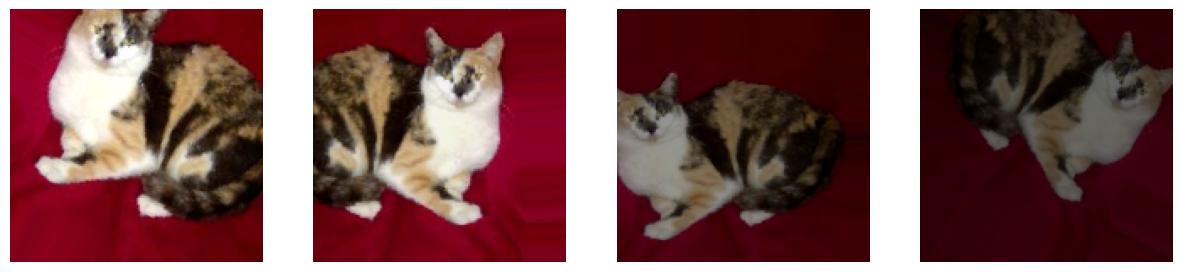

In [13]:
# plotting images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
    img = train_data[5][0][0]
    ax[i].imshow(img)
    ax[i].axis('off')

(150, 150, 3)
0.0


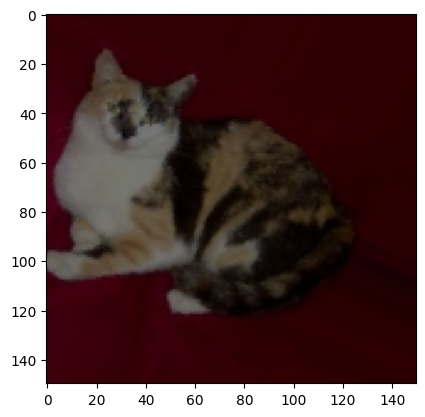

In [14]:
print(train_data[5][0][0].shape)
print(train_data[5][1][0])
plt.imshow(train_data[5][0][0])

(150, 150, 3)
1.0


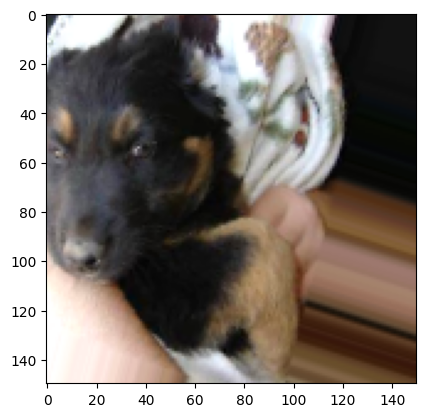

In [15]:
print(train_data[6][0][0].shape)
print(train_data[6][1][0])
plt.imshow(train_data[6][0][0])

* We can also see that Dod = 1 and Cat = 0

### 4. Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single dimension array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [16]:
# Glancec on the data and see if it is normalized
train_data[7][0][0]

array([[[0.7686275 , 0.82745105, 0.8235295 ],
        [0.7725491 , 0.8235295 , 0.8235295 ],
        [0.7843138 , 0.82745105, 0.81568635],
        ...,
        [0.14509805, 0.16078432, 0.1137255 ],
        [0.16078432, 0.17254902, 0.12941177],
        [0.17254902, 0.18431373, 0.16078432]],

       [[0.7686275 , 0.82745105, 0.8235295 ],
        [0.7725491 , 0.8235295 , 0.8235295 ],
        [0.77647066, 0.8235295 , 0.8196079 ],
        ...,
        [0.18039216, 0.19215688, 0.18039216],
        [0.19215688, 0.20392159, 0.20784315],
        [0.20392159, 0.21568629, 0.24313727]],

       [[0.7686275 , 0.82745105, 0.82745105],
        [0.7725491 , 0.82745105, 0.8235295 ],
        [0.7725491 , 0.8235295 , 0.8235295 ],
        ...,
        [0.21176472, 0.22352943, 0.25882354],
        [0.227451  , 0.23137257, 0.2901961 ],
        [0.22352943, 0.227451  , 0.2901961 ]],

       ...,

       [[0.41176474, 0.40784317, 0.24705884],
        [0.40784317, 0.4039216 , 0.24313727],
        [0.41960788, 0

* Values between 0 and 1 it means data is normilized.

In [17]:
# Checking out input\output shape
for i in train_data:
    print(i[0].shape)
    print(i[1].shape)
    print(i[0].shape[1:])
    break

(1, 150, 150, 3)
(1,)
(150, 150, 3)


In [18]:
from keras.metrics import AUC
from keras.metrics import BinaryCrossentropy

model = Sequential()
# Layer 1
model.add(Conv2D(16, (3, 3), input_shape=train_data[0][0].shape[1:])) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# Layer 4
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256)) # Because Dese needs 1D input, we need to flatten the data first.
model.add(Activation('relu'))
# model.add(Dropout(0.2)) # Dropout to prevent overfitting
# Output Layer
model.add(Dense(1)) # Output layer
model.add(Activation('sigmoid')) # Activation Function ( However, comes with layers) . We use sigmoid because we have only 2 classes.

model.compile(loss='binary_crossentropy', # Loss function. We use binary_crossentropy because we have only 2 classes.
              optimizer='adam', # Optimizer. We use adam because it is good default optimizer.
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 148, 148, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4

### 5. Callbacks

**Early Stop**

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The `EarlyStopping` callback is configured when instantiated via arguments.

The `monitor` allows you to specify the performance measure to monitor in order to end training.

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [19]:
earlystop = EarlyStopping(  patience=10,         # Number of epochs with no improvement after which training will be stopped.
                            monitor="val_loss", # Quantity to be monitored.
                            verbose=1)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', # Quantity to be monitored.
                                factor=0.2,        # Factor by which the learning rate will be reduced. new_lr = lr * factor
                                patience=2,        # Number of epochs with no improvement after which learning rate will be reduced.
                                min_lr=0.00001,    # Lower bound on the learning rate.
                                verbose=1)

### 6. Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [21]:
train_data.class_indices

{'Cat': 0, 'Dog': 1}

### 7. Traning Generator

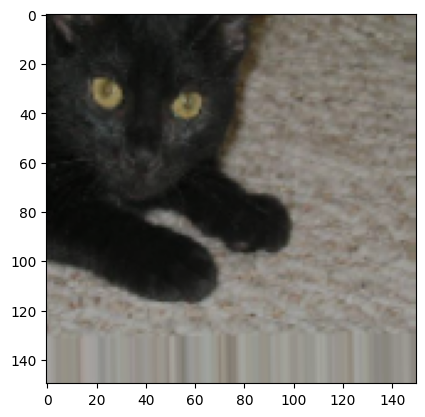

In [22]:
plt.imshow(train_data[0][0][0])

### Validation Generator

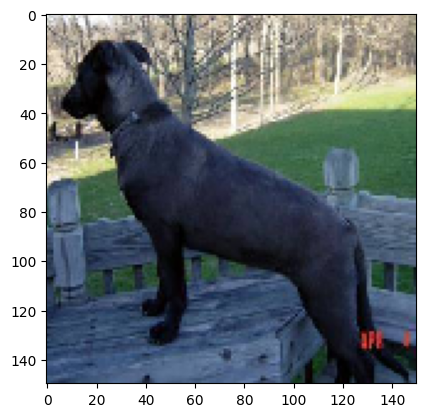

In [23]:
plt.imshow(val_data[2][0][0])

### 8. See how our generator work

Seem to be nice 

### 9. Fit Model

In [24]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VAL=val_data.n//val_data.batch_size

history = model.fit(train_data, validation_data=val_data, 
                    batch_size=32, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr],
                    verbose=1)

Epoch 1/50
2103/2103 [==============================] - 117s 55ms/step - loss: 1.8214 - accuracy: 0.5155 - auc: 0.5251 - binary_crossentropy: 1.8214 - val_loss: 0.6823 - val_accuracy: 0.5296 - val_auc: 0.5903 - val_binary_crossentropy: 0.6823 - lr: 0.0010
Epoch 2/50
2103/2103 [==============================] - 121s 57ms/step - loss: 0.6900 - accuracy: 0.5397 - auc: 0.5528 - binary_crossentropy: 0.6900 - val_loss: 0.6919 - val_accuracy: 0.5161 - val_auc: 0.5299 - val_binary_crossentropy: 0.6919 - lr: 0.0010
Epoch 3/50
2103/2103 [==============================] - 120s 57ms/step - loss: 0.6941 - accuracy: 0.5330 - auc: 0.5435 - binary_crossentropy: 0.6941 - val_loss: 0.6946 - val_accuracy: 0.5000 - val_auc: 0.5351 - val_binary_crossentropy: 0.6946 - lr: 0.0010
Epoch 4/50
2103/2103 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5117 - auc: 0.5190 - binary_crossentropy: 0.6982
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2103/2103 [==

### 10. Save Model

In [25]:
# model.save('CNN-16-32-64.h5')
# # save history to csv
# pd.DataFrame(history.history).to_csv('CNN-16-32-64.csv', index=False)

In [24]:
from keras.models import load_model
model = load_model('CNN-16-32-64.h5')
history = pd.read_csv('CNN-16-32-64.csv')

### 11. Virtualize Training

In [25]:
# print(history.history.keys())
history.head()

loss  accuracy       auc  binary_crossentropy  val_loss  val_accuracy  \
0  1.821362  0.515454  0.525149             1.821362  0.682257      0.529570   
1  0.689961  0.539705  0.552790             0.689961  0.691943      0.516129   
2  0.694093  0.533048  0.543471             0.694093  0.694623      0.500000   
3  0.698215  0.511650  0.519038             0.698215  0.697665      0.508065   
4  0.684029  0.536377  0.564504             0.684029  0.712789      0.532258   

    val_auc  val_binary_crossentropy      lr  
0  0.590314                 0.682257  0.0010  
1  0.529873                 0.691943  0.0010  
2  0.535149                 0.694623  0.0010  
3  0.504307                 0.697665  0.0010  
4  0.513860                 0.712789  0.0002

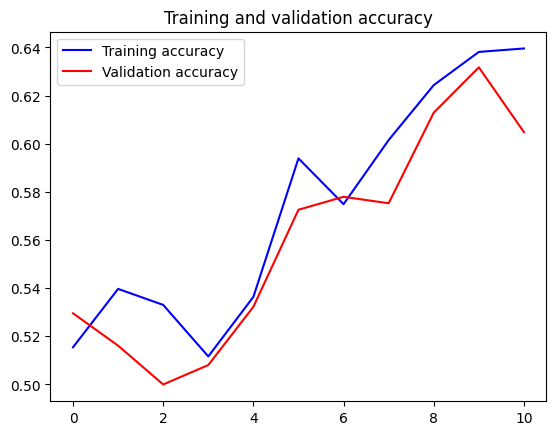

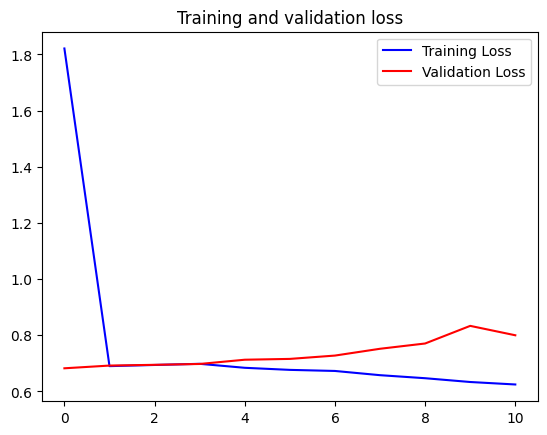

In [26]:
def plot_result(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_result(history)

### 12. Prepare Testing Data

* In a beginning we decided to use our folder "test1_small" as testing data. So we will use it now.
* However, we do not have labels for testing data. So we will predict labels for testing data and compare with actual labels visually.

### 13. Create Testing Generator

* since we decided to use unlabeled data, we need to just predict the data and see it to compare how acurate prediction is.

### 14. Predict

* we remember we have 2 classes - 0 - Dog, 1 - Cat.
* I have manually labeled 20 or so pictures from the test data and added few pics of our dog for fun. 
* Since model was giving val_accuracy: 0.6048  before we stopped the training, I think it will be only somewhat better than coin flip.

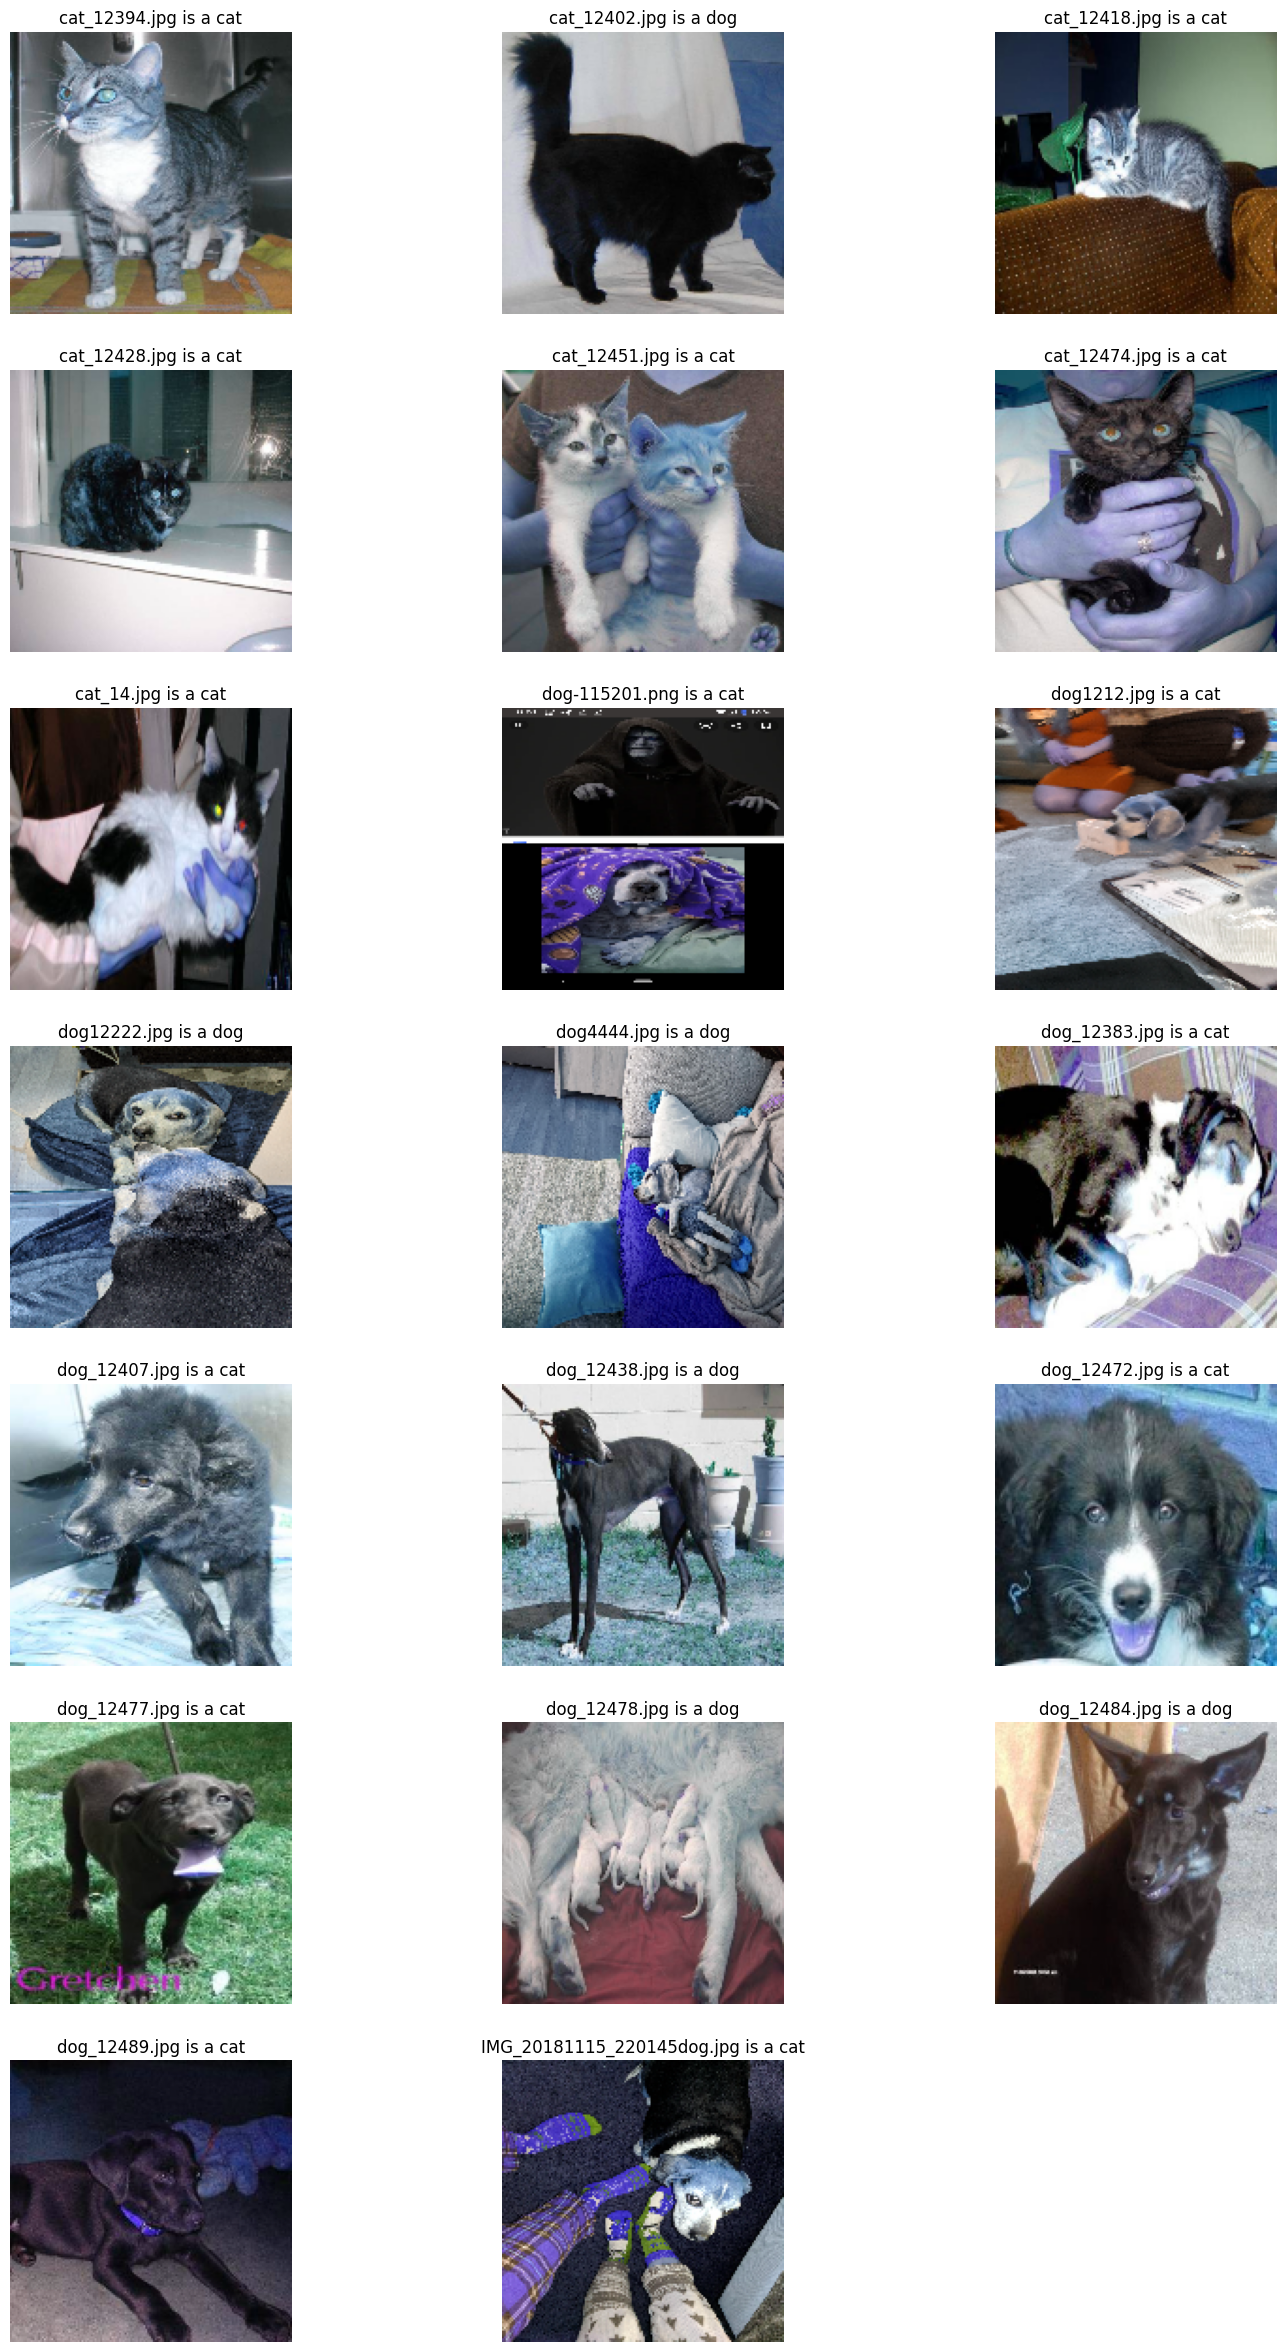

In [31]:

%matplotlib inline

fig = plt.figure(figsize=(18, 30))
rows = 7
columns = 3

n=0
for dirobject in os.scandir(TEST_DATADIR):
    if dirobject.is_file():
        if ('cat' in dirobject.name) or ('dog' in dirobject.name):
            n += 1
            img_array = cv2.imread(dirobject.path, cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, IMAGE_SIZE)

            fig.add_subplot(rows, columns, n)
            plt.imshow(new_array)
            plt.axis('off')

            batch = np.expand_dims(new_array, axis=0)
            result = model.predict(batch, verbose=0)

            if result[0][0] == 0:
                plt.title(f'{dirobject.name} is a cat')
            else:
                plt.title(f'{dirobject.name} is a dog')
